In [14]:
import os
import json
from pathlib import Path
import typing

import numpy as np
import torch
from transformers import OpenAIGPTLMHeadModel, OpenAIGPTConfig
import pandas as pd
import matplotlib.pyplot as plt

from muutils.logger import Logger, TimerContext
from muutils.json_serialize import json_serialize, dataclass_serializer_factory
from muutils.tensor_utils import ATensor, NDArray
from muutils.statcounter import StatCounter
from muutils.misc import shorten_numerical_to_str

import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from maze_transformer.generation.latticemaze import LatticeMaze
from maze_transformer.generation.generators import LatticeMazeGenerators
from maze_transformer.training.tokenizer import MazeTokenizer, SPECIAL_TOKENS
from maze_transformer.training.mazedataset import MazeDatasetConfig, MazeDataset
from maze_transformer.evaluation.plot_maze import plot_multi_paths, PathFormat
from maze_transformer.training.dataset import GPTDatasetConfig
from maze_transformer.training.config import TrainConfig
from maze_transformer.training.training import TRAIN_SAVE_FILES
from maze_transformer.evaluation.eval_model import generate_plot_predicted_path, MazePath, load_model_with_configs, LoadedModelConfigs, predict_maze_path
from maze_transformer.evaluation.pathdist import MazeEvalFunction, ArrMazeEvalFunction, MazeEvalFuncs, ArrMazeEvalFuncs
from maze_transformer.evaluation.eval_model import decode_maze_tokens_to_coords, predict_tokens, pad_sequence
from maze_transformer.evaluation.plot_attention import colorize


In [15]:
# load model and configs
model_path: str = "data/g4-n4K/g4-n4K_tiny-v1_2022-10-05-02-03-44/model.final.pt"
loaded_model_and_configs: LoadedModelConfigs = load_model_with_configs(model_path, MazeDatasetConfig)
data_cfg: MazeDatasetConfig; train_cfg: TrainConfig
model_cfg: OpenAIGPTConfig; model: OpenAIGPTLMHeadModel
data_cfg, train_cfg, model_cfg, model = loaded_model_and_configs

model.config.max_length = model_cfg.n_positions + 1
model.config.output_attentions = True


loaded model with 28M parameters


In [16]:

# generate a maze

grid_n: int = data_cfg.grid_n
maze: LatticeMaze = LatticeMazeGenerators.gen_dfs((grid_n, grid_n))
c_start = (0, 0)
c_end = (grid_n - 1, grid_n - 1)

# solve the maze explicitly
path_true = np.array(maze.find_shortest_path(
	c_start = c_start,
	c_end = c_end,
))

solved_maze: MazeTokenizer = MazeTokenizer(
	maze=maze,
	solution=np.array(maze.find_shortest_path(
		c_start=c_start,
		c_end=c_end,
	)),
)

# tokenize the maze
maze_only_tokens: list[str] = solved_maze.as_tokens(data_cfg.node_token_map , solution = False) + [ SPECIAL_TOKENS["start_path"] ]

print("maze tokens:", maze_only_tokens)

array_nopad = torch.tensor(
	[ data_cfg.tokenizer_map[t] for t in maze_only_tokens ], 
	dtype=torch.int32,
	device="cpu",
)

array: ATensor = pad_sequence(array_nopad, model_cfg)



maze tokens: ['<ADJLIST_START>', '(2,1)', '<-->', '(2,2)', ';', '(2,2)', '<-->', '(2,3)', ';', '(3,2)', '<-->', '(3,3)', ';', '(2,0)', '<-->', '(1,0)', ';', '(0,0)', '<-->', '(0,1)', ';', '(1,2)', '<-->', '(1,1)', ';', '(2,0)', '<-->', '(3,0)', ';', '(3,2)', '<-->', '(3,1)', ';', '(0,2)', '<-->', '(1,2)', ';', '(3,3)', '<-->', '(2,3)', ';', '(0,2)', '<-->', '(0,1)', ';', '(1,2)', '<-->', '(1,3)', ';', '(1,3)', '<-->', '(0,3)', ';', '(2,0)', '<-->', '(2,1)', ';', '(0,0)', '<-->', '(1,0)', ';', '(3,1)', '<-->', '(3,0)', ';', '<ADJLIST_END>', '<TARGET_START>', '(3,3)', '<TARGET_END>', '<START_PATH>']


In [17]:
# have the model predict some tokens

n_positions: int = model_cfg.n_positions

context_str: list[str] = maze_only_tokens[-model.config.n_positions:]
# left pad with <NULL>
context_str = [
	SPECIAL_TOKENS["padding"] 
	for _ in range(
		n_positions - len(context_str)
	)
] + context_str
context_tokenized: list[int] = array[-model.config.n_positions:]

with torch.no_grad():
	output = model(array[-model.config.n_positions:])

print(f"{output.logits.shape = }\n{len(output.attentions) = }\n{[x.shape for x in output.attentions] = }")

# `output.attentions` is a tuple of tensors, where each element of the tuple corresponds to a layer. The tensor has dimensions (1, n_heads, n_positions, n_positions)


output.logits.shape = torch.Size([90, 25])
len(output.attentions) = 4
[x.shape for x in output.attentions] = [torch.Size([1, 2, 90, 90]), torch.Size([1, 2, 90, 90]), torch.Size([1, 2, 90, 90]), torch.Size([1, 2, 90, 90])]


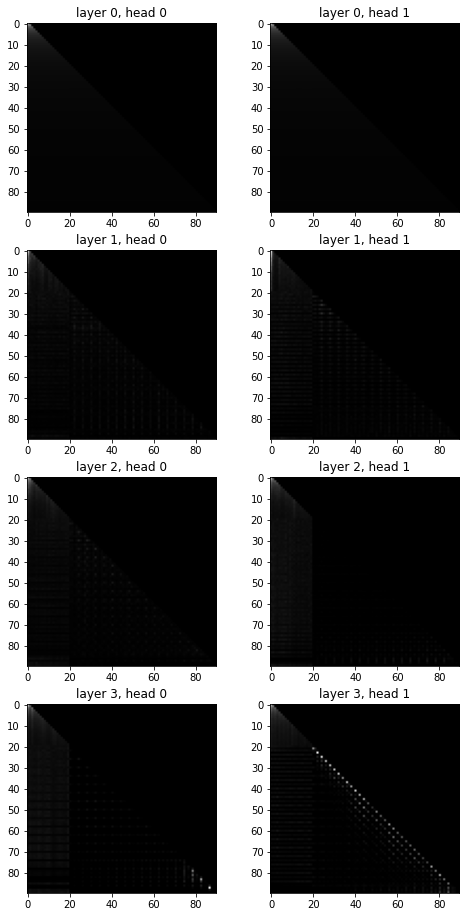

In [18]:
n_layers: int = len(output.attentions)
n_heads: int = output.attentions[0].shape[1]
fig, axs = plt.subplots(n_layers, n_heads, figsize=(4 * n_heads, 4 * n_layers))

for layer_idx, layer in enumerate(output.attentions):
	for head_idx, head in enumerate(layer[0]):
		axs[layer_idx, head_idx].imshow(head.cpu().numpy(), cmap="gray")
		axs[layer_idx, head_idx].set_title(f"layer {layer_idx}, head {head_idx}")

		# set x and y axes to words from context_str
		# axs[layer_idx, head_idx].set_xticks(range(n_positions), context_str)
		# axs[layer_idx, head_idx].set_yticks(range(n_positions), context_str)

		# # rotate x axis labels
		# plt.setp(axs[layer_idx, head_idx].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.show()

	

In [19]:
print(predictions)

# decode the tokens
predicted_tokens = [ data_cfg.token_arr[t] for t in predictions[0] ]

print(predicted_tokens)

path_predicted: list[tuple[int,int]] = decode_maze_tokens_to_coords(
	predicted_tokens[len(maze_only_tokens):],
	mazedata_cfg = data_cfg, 
	when_noncoord = "skip",
)

# plot the maze and both solutions
# for label, fmt, color, path in paths
plot_multi_paths(
	maze = maze,
	paths = [
		PathFormat(path_true, "true", "-", "red", {'width': 0.015}),
		PathFormat(np.array(path_predicted), "predicted", ":", "blue", {}),
	],
)

NameError: name 'predictions' is not defined